# Uplift Random Forest

In [ ]:
import sys
sys.path.append("/home/mori/Documents/h2o/env/h2o-env/lib/python3.7/site-packages")
sys.path.append("/home/mori/Documents/h2o/code/h2o-3/h2o-py/")

In [2]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split

import h2o
from causalml.metrics import plot_gain, plot_qini, plot_lift
from causalml.metrics import auuc_score
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [64]:
# Data generation
df, feature_cols = make_uplift_classification(n_samples=100000, 
                                              treatment_name=["control", "treatment"],
                                              n_classification_features=10,
                                              n_classification_informative=10)

# Rename features for easy interpretation of visualization
feature_cols_new = ['feature_%s'%(i) for i in range(len(feature_cols))]
rename_dict = {feature_cols[i]:feature_cols_new[i] for i in range(len(feature_cols))}
df = df.rename(columns=rename_dict)
feature_cols = feature_cols_new

print(df.head())

df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

  treatment_group_key  feature_0  feature_1  feature_2  feature_3  feature_4  \
0           treatment  -0.696589  -1.531339   0.598504  -0.442362  -3.368640   
1           treatment  -1.734370  -2.894930   3.653897  -0.844279  -3.343867   
2             control  -0.438270   0.038893   2.287993   1.545793  -3.453372   
3           treatment  -1.502139   1.692400   0.210930   1.052463  -2.866955   
4             control   2.535457   0.329222   0.580543   0.694155  -1.255418   

   feature_5  feature_6  feature_7  feature_8  feature_9  conversion  \
0   0.207879   1.487930  -2.754940  -2.228405   2.049576           0   
1   4.015698   2.660818  -3.401851  -4.275002   3.593160           0   
2   4.346322   3.289635   1.703655  -1.959676   1.735490           0   
3   1.522505   1.157297   2.280189  -2.859386   0.907246           0   
4  -0.079855  -3.113221   0.017193   2.156657   1.439771           0   

   treatment_effect  
0                 0  
1                 0  
2                 0 

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.49838,100000
treatment,0.50194,100000
All,0.50016,200000


In [65]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
df_train.shape, df_test.shape

((160000, 13), (40000, 13))

In [69]:
ntree = 50
max_depth = 20
control_name = "control"
treatment_column = "treatment_group_key"
response_column = "conversion"
metric="ChiSquared"

## CausalML

In [70]:
# Train CausalML uplift tree
causalml_uplift_model = UpliftRandomForestClassifier(
        n_estimators=ntree,
        max_depth=max_depth,
        evaluationFunction=metric,
        control_name=control_name,
        min_samples_leaf=10,
        min_samples_treatment=10,
        normalization=False,
        random_state=42)

causalml_uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_column].values,
                 y=df_train[response_column].values)

#df_test = df_train
causalml_preds = causalml_uplift_model.predict(df_test.values)

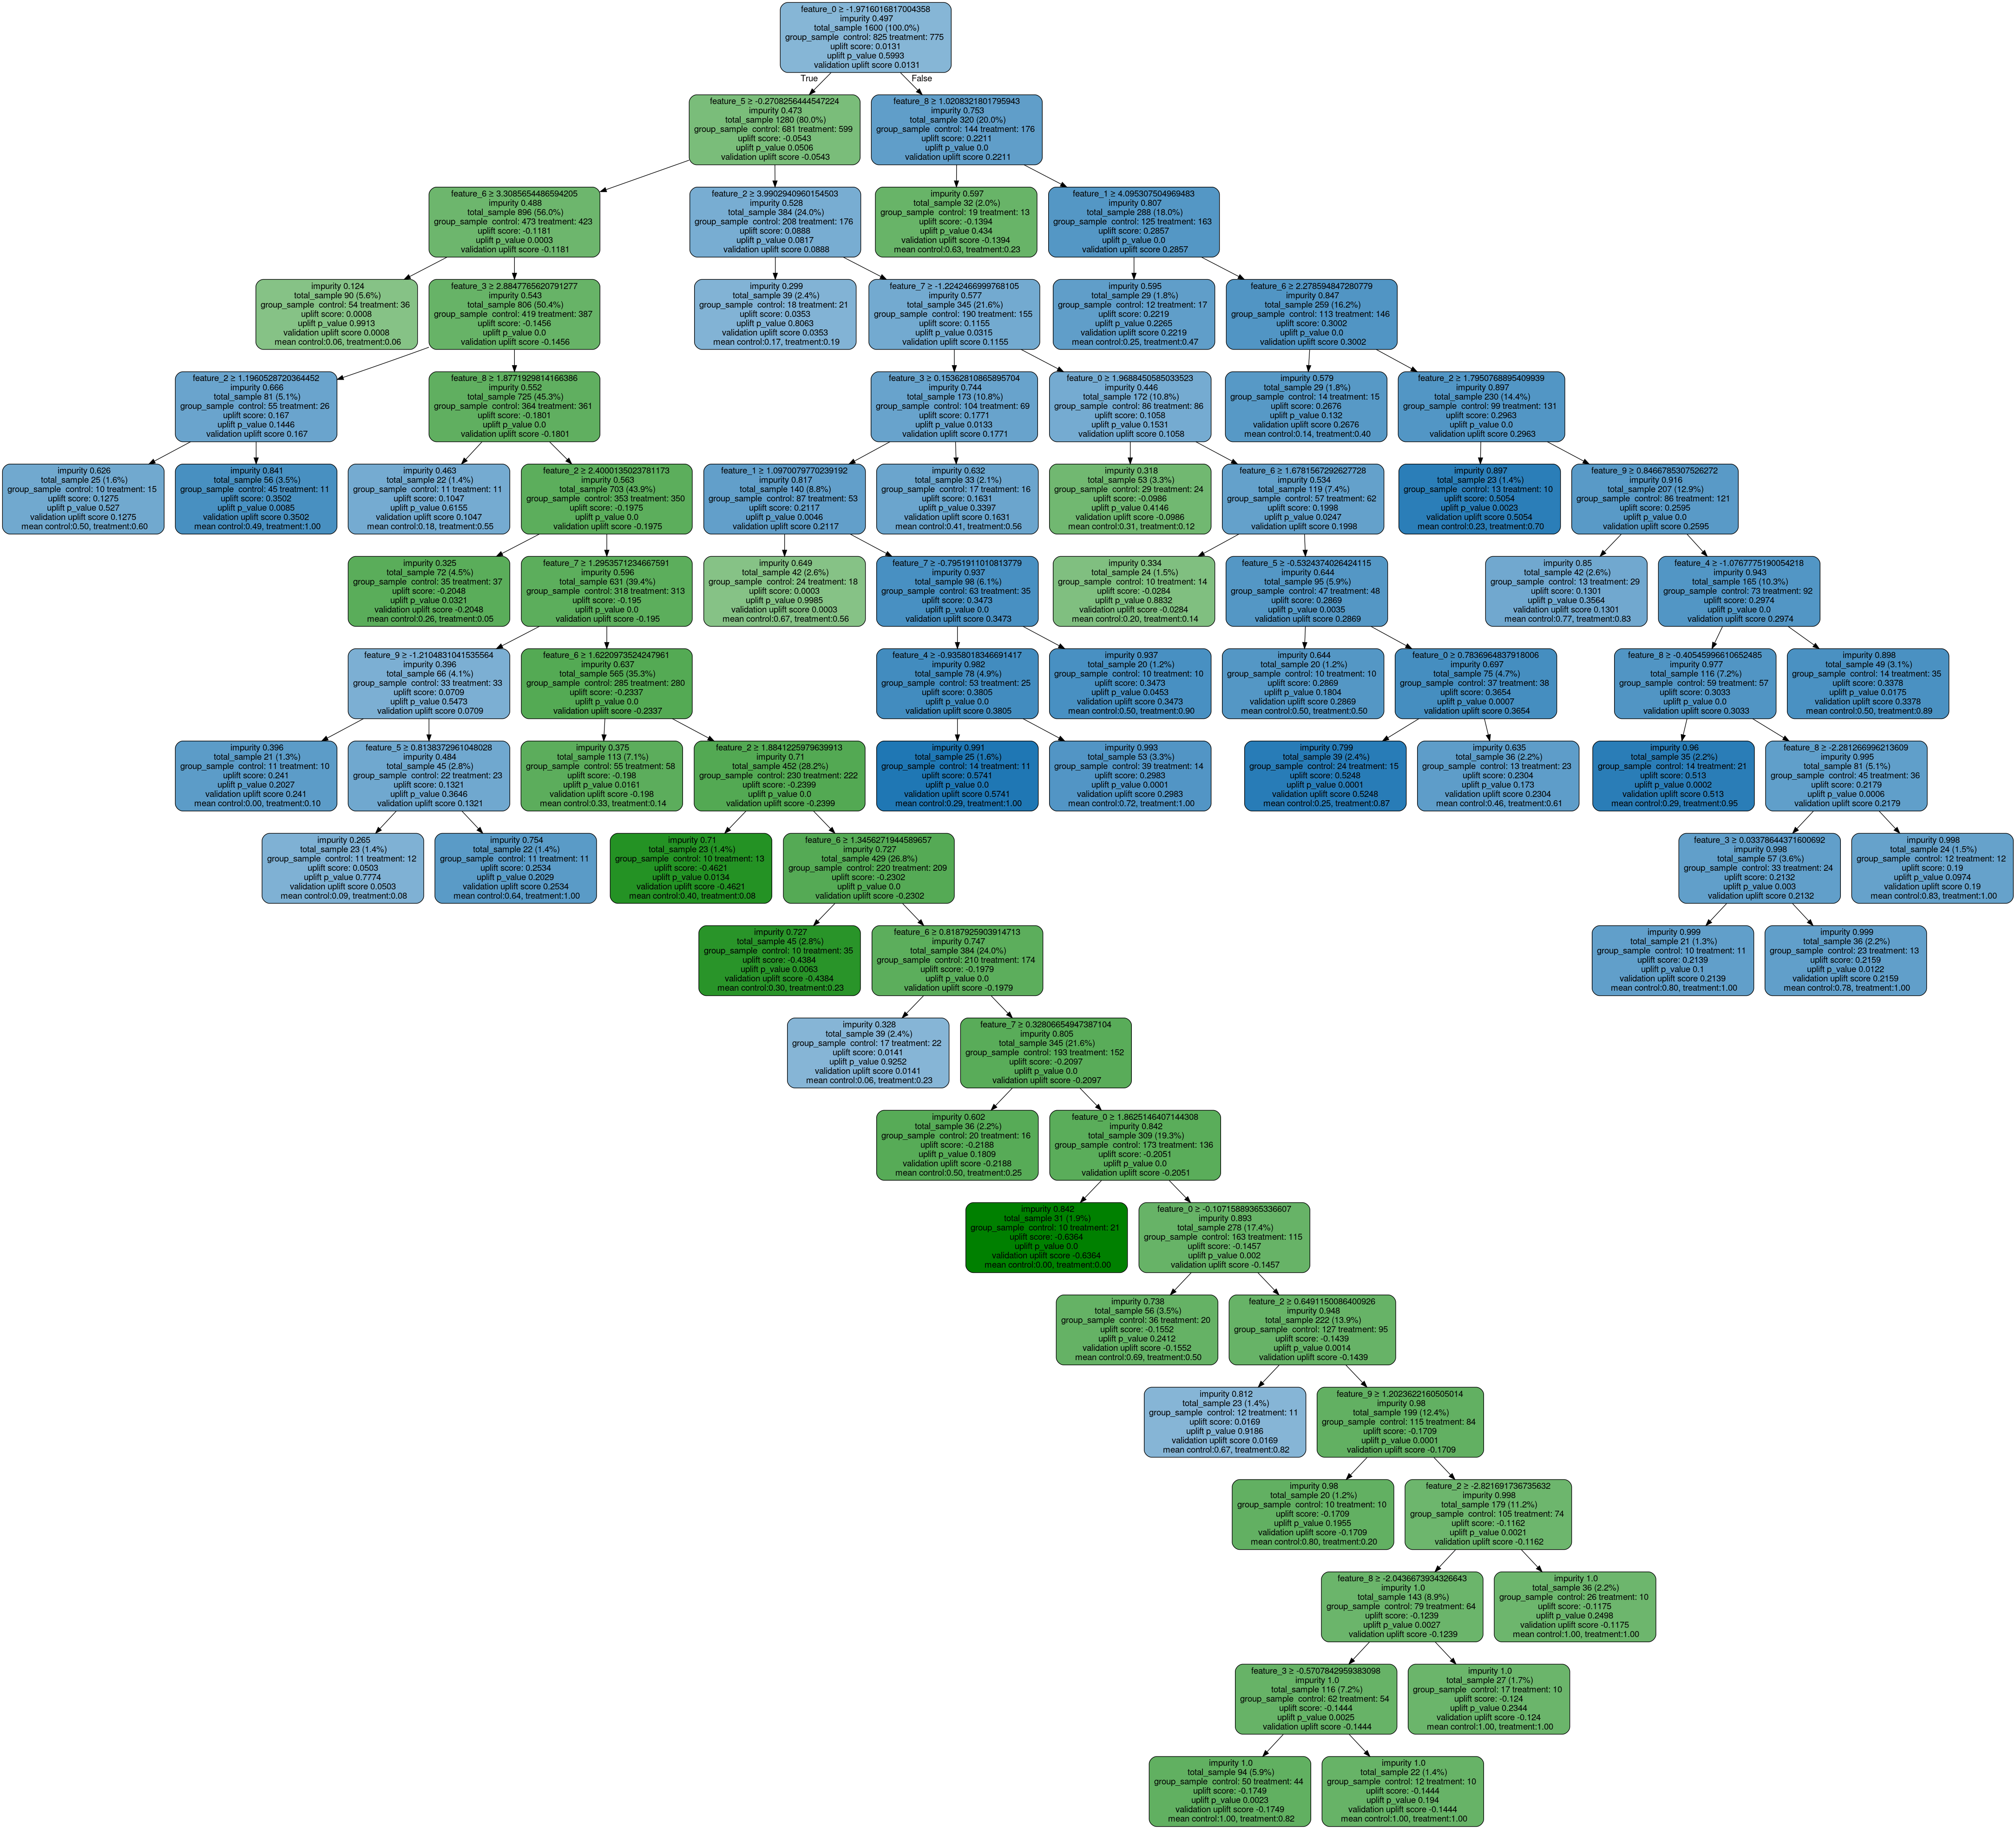

In [22]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[0].fitted_uplift_tree, feature_cols)
Image(graph.create_png())

## H2O-3

In [8]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,19 hours 16 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 27 minutes
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.786 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [71]:
train_h2o = h2o.H2OFrame(df_train)
train_h2o[treatment_column] = train_h2o[treatment_column].asfactor()
train_h2o[response_column] = train_h2o[response_column].asfactor()
h2o_uplift_model = H2OUpliftRandomForestEstimator(
            ntrees=ntree,
            max_depth=max_depth-1,
            treatment_column=treatment_column,
            uplift_metric=metric,
            gainslift_bins=10,
            min_rows=10,
            nbins=1000,
            seed=42,
            sample_rate=0.99,
            auuc_type="gain",
            score_each_iteration=False)
h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=train_h2o)
h2o_uplift_model

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Model Details
H2OUpliftRandomForestEstimator :  Uplift Distributed Random Forest
Model Key:  UpliftDRF_model_python_1628251170902_71


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,100.0,680327.0,18.0,19.0,18.98,130.0,911.0,536.46




ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 13.032444225045198

Scoring History: 


,,timestamp,duration,number_of_trees,training_auuc
0,,2021-08-06 15:04:29,0.014 sec,0.0,NaN
1,,2021-08-06 15:04:30,0.794 sec,1.0,0.000000
2,,2021-08-06 15:04:31,1.369 sec,2.0,-3.968262
3,,2021-08-06 15:04:32,2.219 sec,3.0,15.282705
4,,2021-08-06 15:04:32,3.111 sec,4.0,17.139592
5,,2021-08-06 15:04:38,9.025 sec,16.0,-71.914071
6,,2021-08-06 15:04:44,14.662 sec,27.0,-56.295130
7,,2021-08-06 15:04:51,21.570 sec,40.0,-83.347311
8,,2021-08-06 15:04:56,27.094 sec,50.0,13.032444


In [72]:
test_h2o = h2o.H2OFrame(df_test)
preds_h2o = h2o_uplift_model.predict(test_h2o)
preds_h2o

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf prediction progress: |█████████████████████████████████████████████████| (done) 100%


uplift_predict,p_y1_ct1,p_y1_ct0
0.012357,0.309567,0.29721
-0.00655355,0.137092,0.143645
0.0283462,0.282983,0.254637
0.00715781,0.133092,0.125934
-0.00601521,0.333928,0.339943
-0.00440368,0.134313,0.138716
0.0264288,0.37868,0.352251
-0.00288689,0.0298699,0.0327568
0.00747203,0.184387,0.176915
-0.00244138,0.864581,0.867023


In [73]:
preds_comp = preds_h2o["uplift_predict"]
preds_comp.names = ["h2o"]
preds_comp["causal"] = h2o.H2OFrame(causalml_preds)
preds_comp["diff"] = abs(preds_comp["h2o"] - preds_comp["causal"])
preds_comp[treatment_column] = h2o.H2OFrame(df_test[treatment_column].values)
preds_comp[response_column] = h2o.H2OFrame(df_test[response_column].values)
preds_comp.summary()
    
min_diff = preds_comp["diff"].min()
max_diff = preds_comp["diff"].max()
mean_diff = preds_comp["diff"].mean(return_frame=False)[0]
print("min: %f max: %f mean: %f" % (min_diff, max_diff, mean_diff))

results = preds_comp.as_data_frame()
results = results[["h2o", "causal", response_column, treatment_column]]
mapping = {'control': 0, 'treatment': 1}
results = results.replace({treatment_column: mapping})


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,h2o,causal,diff,treatment_group_key,conversion
type,real,real,real,enum,int
mins,-0.1472062742710114,-0.14174418000000033,1.7658767714756607e-07,,0.0
mean,0.0025819512421382256,-0.011177897901500066,0.02647853856319198,,0.498775
maxs,0.11966263487469406,0.09505591999999996,0.18708947427101144,,1.0
sigma,0.01588463194667597,0.02544318015285266,0.020406840690107703,,0.5000047494711799
zeros,0,0,0,,20049
missing,0,0,0,0,0
0,0.012356951432302588,0.03009892000000014,0.017741968567697552,control,0.0
1,-0.006553552537225171,0.031758300000000045,0.038311852537225216,control,0.0
2,0.028346235924400387,-0.03833259999999994,0.06667883592440033,treatment,0.0


min: 0.000000 max: 0.187089 mean: 0.026479


In [74]:
auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=False)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O AUUC:
182.013058260422
CauslML AUUC:
140.82596122675955
Random AUUC:
119.51089878740537


In [75]:
perf_h2o = h2o_uplift_model.model_performance(test_h2o)
auuc_h2o = perf_h2o.auuc()
print("H2O training metrics AUUC Gain: "+str(auuc_h2o))


H2O training metrics AUUC Gain: 182.08548715585385


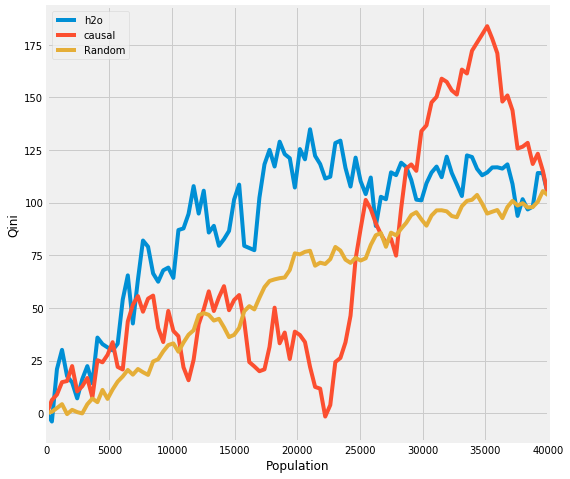

In [76]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column)

1000
[40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000, 1040, 1080, 1120, 1160, 1200, 1240, 1280, 1320, 1360, 1400, 1440, 1480, 1520, 1560, 1600, 1640, 1680, 1720, 1760, 1800, 1840, 1880, 1920, 1960, 2000, 2040, 2080, 2120, 2160, 2200, 2240, 2280, 2320, 2360, 2400, 2440, 2480, 2520, 2560, 2600, 2640, 2680, 2720, 2760, 2800, 2840, 2880, 2920, 2960, 3000, 3040, 3080, 3120, 3160, 3200, 3240, 3280, 3320, 3360, 3400, 3440, 3480, 3520, 3560, 3600, 3640, 3680, 3720, 3760, 3800, 3840, 3880, 3920, 3960, 4000, 4040, 4080, 4120, 4160, 4200, 4240, 4280, 4320, 4360, 4400, 4440, 4480, 4520, 4560, 4600, 4640, 4680, 4720, 4760, 4800, 4840, 4880, 4920, 4960, 5000, 5040, 5080, 5120, 5160, 5200, 5240, 5280, 5320, 5360, 5400, 5440, 5480, 5520, 5560, 5600, 5640, 5680, 5720, 5760, 5800, 5840, 5880, 5920, 5960, 6000, 6040, 6080, 6120, 6160, 6200, 6240, 6280, 6320, 6360, 6400, 6440, 6480, 6520, 6560, 6600, 6640, 6680, 6720, 6760, 6800, 

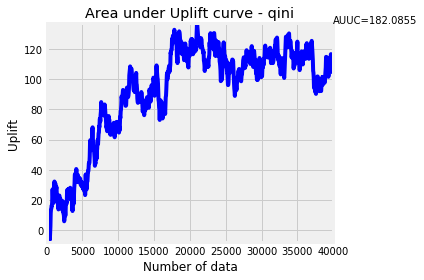

In [83]:
n, uplift = perf_h2o.plot_auuc(metric="qini", plot=False)
print(len(n))
print(n)
print(uplift)
perf_h2o.plot_auuc(metric="qini")

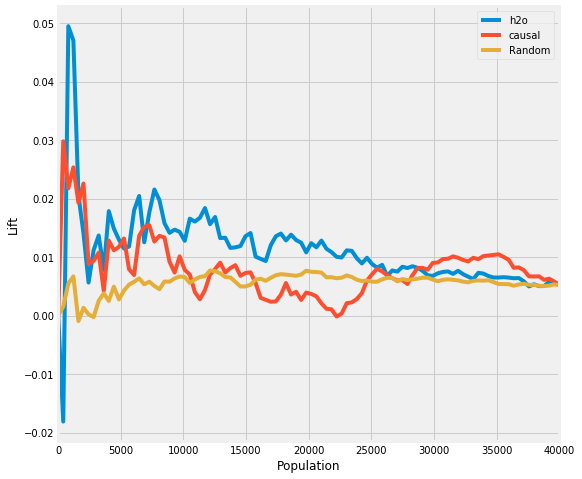

In [82]:
plot_lift(results, outcome_col=response_column, treatment_col=treatment_column)


[40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000, 1040, 1080, 1120, 1160, 1200, 1240, 1280, 1320, 1360, 1400, 1440, 1480, 1520, 1560, 1600, 1640, 1680, 1720, 1760, 1800, 1840, 1880, 1920, 1960, 2000, 2040, 2080, 2120, 2160, 2200, 2240, 2280, 2320, 2360, 2400, 2440, 2480, 2520, 2560, 2600, 2640, 2680, 2720, 2760, 2800, 2840, 2880, 2920, 2960, 3000, 3040, 3080, 3120, 3160, 3200, 3240, 3280, 3320, 3360, 3400, 3440, 3480, 3520, 3560, 3600, 3640, 3680, 3720, 3760, 3800, 3840, 3880, 3920, 3960, 4000, 4040, 4080, 4120, 4160, 4200, 4240, 4280, 4320, 4360, 4400, 4440, 4480, 4520, 4560, 4600, 4640, 4680, 4720, 4760, 4800, 4840, 4880, 4920, 4960, 5000, 5040, 5080, 5120, 5160, 5200, 5240, 5280, 5320, 5360, 5400, 5440, 5480, 5520, 5560, 5600, 5640, 5680, 5720, 5760, 5800, 5840, 5880, 5920, 5960, 6000, 6040, 6080, 6120, 6160, 6200, 6240, 6280, 6320, 6360, 6400, 6440, 6480, 6520, 6560, 6600, 6640, 6680, 6720, 6760, 6800, 6840,

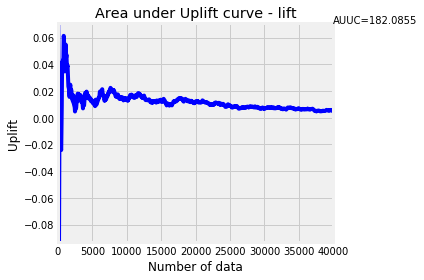

In [81]:
n, uplift = perf_h2o.plot_auuc(metric="lift", plot=False)
print(n)
print(uplift)
perf_h2o.plot_auuc(metric="lift")

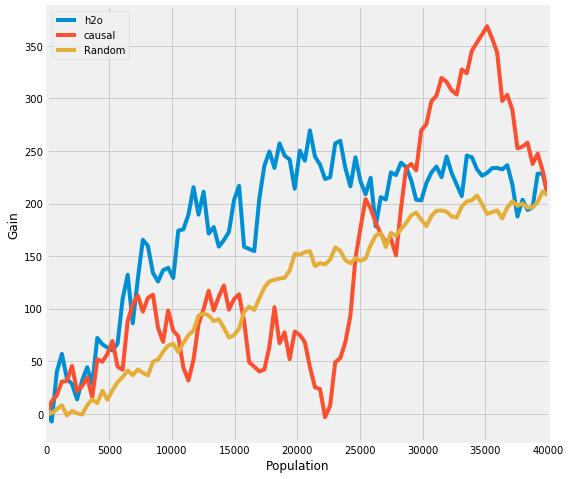

In [78]:
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column)

In [ ]:
n, uplift = perf_h2o.plot_auuc(metric="gain", plot=False)
print(n)
print(uplift)
perf_h2o.plot_auuc(metric="gain")

In [80]:
from h2o.estimators import H2OGradientBoostingEstimator

# Import the prostate dataset into H2O:
data = h2o.import_file("../../smalldata/testng/covtype_small_dense_multiclass_unbalanced.csv")

# Set the predictors and response; set the factors:
features = ['x%d' % i for i in range(1, 54, 1)]

for f in features[11:]:
    data[f] = data[f].asfactor()
    
response = "response"

# Build and train the model:
pros_gbm = H2OGradientBoostingEstimator(max_depth=0,
                                        seed=1111,
                                        min_split_improvement=1e-6)
pros_gbm.train(x=features, y=response, training_frame=data)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1628251170902_91


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,350.0,2442669.0,8.0,69.0,38.925713,20.0,581.0,550.0486




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 9.323946263648722e-05
RMSE: 0.009656058338498542
LogLoss: 0.0041458490792248386
Mean Per-Class Error: 0.0
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,x1,x2,x3,x4,x5,x6,x7,Error,Rate
0,201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0 / 201
1,0.0,6022.0,0.0,0.0,0.0,0.0,0.0,0.0,"0 / 6,022"
2,0.0,0.0,201.0,0.0,0.0,0.0,0.0,0.0,0 / 201
3,0.0,0.0,0.0,201.0,0.0,0.0,0.0,0.0,0 / 201
4,0.0,0.0,0.0,0.0,201.0,0.0,0.0,0.0,0 / 201
5,0.0,0.0,0.0,0.0,0.0,201.0,0.0,0.0,0 / 201
6,0.0,0.0,0.0,0.0,0.0,0.0,201.0,0.0,0 / 201
7,201.0,6022.0,201.0,201.0,201.0,201.0,201.0,0.0,"0 / 7,228"



Top-7 Hit Ratios: 


,k,hit_ratio
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,1.0
6,7,1.0



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-08-06 15:11:18,0.007 sec,0.0,0.857143,1.945910,0.303818,NaN,NaN
1,,2021-08-06 15:11:18,0.456 sec,1.0,0.762596,1.443673,0.057969,NaN,NaN
2,,2021-08-06 15:11:18,0.788 sec,2.0,0.682852,1.157529,0.050775,NaN,NaN
3,,2021-08-06 15:11:19,1.121 sec,3.0,0.611521,0.955533,0.046763,NaN,NaN
4,,2021-08-06 15:11:19,1.491 sec,4.0,0.547809,0.802774,0.044411,NaN,NaN
5,,2021-08-06 15:11:19,1.818 sec,5.0,0.490420,0.680761,0.041782,NaN,NaN
6,,2021-08-06 15:11:20,2.144 sec,6.0,0.439537,0.582122,0.038738,NaN,NaN
7,,2021-08-06 15:11:20,2.487 sec,7.0,0.394311,0.500411,0.035556,NaN,NaN
8,,2021-08-06 15:11:21,2.880 sec,8.0,0.354395,0.432120,0.030852,NaN,NaN
9,,2021-08-06 15:11:21,3.274 sec,9.0,0.319531,0.374936,0.028085,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,x1,4107.558105,1.000000,0.518498
1,x10,689.289001,0.167810,0.087009
2,x6,533.855225,0.129969,0.067389
3,x4,387.189819,0.094263,0.048875
4,x7,328.220123,0.079906,0.041431
5,x5,257.141479,0.062602,0.032459
6,x2,228.516708,0.055633,0.028846
7,x8,208.587921,0.050781,0.026330
8,x9,180.881653,0.044036,0.022833
9,x3,163.125107,0.039713,0.020591



See the whole table with table.as_data_frame()
